# Tomographic reconstruction in four dimensions 
- comments: true
- toc: false
- badges: false
- image: images/vary_n_angles.gif
- categories: [physics, accelerators, tomography]
- author: Austin Hoover

## Introduction

A beam of particles in an accelerator is characterized by its distribution in phase space — the space of positions $\{x, y, z\}$ and momenta $\{x', y', z'\}$. I'm currently working on a project in which we'd like to measure the four-dimensional (4D) phase space distribution $f(x, x', y, y')$ of a fully-accumulated beam in the Spallation Neutron Source (SNS). 

A direct way to do this is to use a series of slits to block all particles outside a small region $\mathbf{x} \pm \Delta\mathbf{x}$, where $\mathbf{x} = (x, x', y, y')$, and move $\mathbf{x}$ through phase space. This method is accurate but slow and not available for our beam ($10^{14}$ protons moving at 90% the speed of light). The best we can do is to measure projections of the distribution; i.e., a lower-dimensional views such as

$$
f(x) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}{f(x, x', y, y') dx' dy dy'}
$$

and estimating the distribution from these projections. This is called *tomographic reconstruction*.

Tomographic reconstruction is used in a wide variety of fields, particularly in medical imaging where X-rays are used to generate 1D projections of a 2D slice of organic material at various angles. The same idea can be applied to a phase space distribution. Consider $f(x, x')$. It's straightforward to measure a 1D projection along the $x$ axis by sweeping a vertical conducting wire across the beam path; the problem is that this only corresponds to one projection angle. The trick is to approximate the motion in an accelerator as a series of linear transformations of the phase space coordinates: shearing, scaling, and rotation. Thus, the projection of a beam at one location onto the $x$ axis is a scaled projection of a projection onto a rotated axis at a different location. The projection angle can be controlled by varying the electromagnetic fields between the two locations.

It's more challenging to find $f(x, x', y, y')$. It's simple to reconstruct the $4 \times 4$ covariance matrix from 1D projections; I've [implemented this method in the SNS](link) and won't discuss it here. To obtain the 4D *distribution*, we generally need at least 2D projections. I'm interested in this approach because the final destination of the SNS beam — the target — is coated with a luminescent material which gives the 2D projection onto the $x$-$y$ plane. The idea that I'll begin to explore in this post is whether these 2D projections can be used to reconstruct the 4D phase space distribution. I'll first go over the common reconstruction algorithms in 2D and mention if they could be extended to 4D.

## Reconstruction algorithms in 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
from skimage import transform

In [2]:
#hide
import sys
sys.path.append('/Users/austin/Research/')
from accphys.tools import plotting as myplt

pplt.rc['axes.grid'] = False
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'dusk_r'
pplt.rc['savefig.dpi'] = 'figure'
pplt.rc['animation.html'] = 'jshtml'
savefig_kws = dict(dpi=300)

I'll use the following distribution to test the reconstruction algorithms.

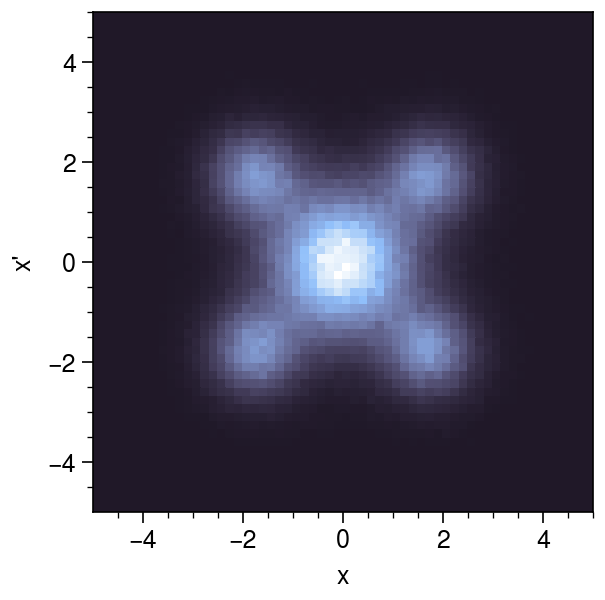

In [3]:
a = 1.75
n = 300000
X = np.vstack([
    np.random.normal(scale=[1.0, 1.0], loc=[0.0, 0.0], size=(n, 2)),
    np.random.normal(scale=0.6, loc=[+a, +a], size=(n//5, 2)),
    np.random.normal(scale=0.6, loc=[+a, -a], size=(n//5, 2)),
    np.random.normal(scale=0.6, loc=[-a, +a], size=(n//5, 2)),
    np.random.normal(scale=0.6, loc=[-a, -a], size=(n//5, 2)),
])

n_bins = 60
xmax = 5.0
limits = [(-xmax, xmax), (-xmax, xmax)]

Z_true, xedges, yedges = np.histogram2d(X[:, 0], X[:, 1], n_bins, limits, density=True)
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

fig, ax = pplt.subplots()
ax.pcolormesh(xcenters, ycenters, Z_true.T)
ax.format(xlabel="x", ylabel="x'")
plt.show()

We now simulate the measurements. Assume we have the ability to rotate the distribution without any shearing or scaling. We then rotate the distribution by different angles and project it onto the $x$ axis. It will turn out that measurement time limits the number of projections we can use; for now, we'll limit ourselves to 15 projections. 

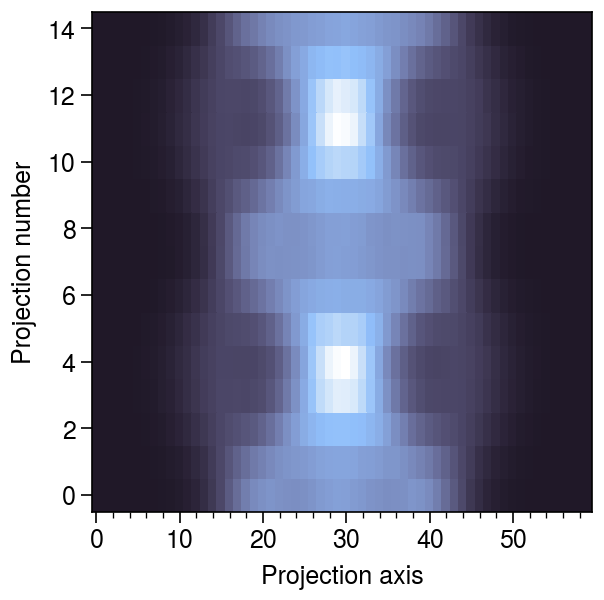

In [5]:
def rotation_matrix(angle):
    cs, sn = np.cos(angle), np.sin(angle)
    return np.array([[cs, sn], [-sn, cs]])

n_proj = 15
angles = np.linspace(0., 180., n_proj, endpoint=False)
transfer_matrices = [rotation_matrix(np.radians(angle)) for angle in angles]
projections = np.zeros((n_bins, n_proj))
for k in range(n_proj):
    M = transfer_matrices[k]
    X_meas = np.apply_along_axis(lambda row: np.matmul(M, row), 1, X)
    projections[:, k], _ = np.histogram(X_meas[:, 0], n_bins, limits[0], density=True)
    
fig, ax = pplt.subplots()
ax.pcolormesh(projections.T)
ax.format(xlabel='Projection axis', ylabel='Projection number', ytickminor=False)

We'll also need some helper functions.

In [49]:
def apply(M, X):
    return np.apply_along_axis(lambda row: np.matmul(M, row), 1, X)

def project(Z, indices):
    if type(indices) is int:
        indices = [indices]
    axis = tuple([k for k in range(4) if k not in indices])
    return np.sum(Z, axis=axis)

def normalize(Z, bin_volume=1.0):
    count = np.sum(Z)
    if count == 0.0:
        return Z
    return Z / count / bin_volume

def get_bin_volume(limits, n_bins):
    if type(n_bins) is int:
        n_bins = len(limits) * [n_bins]
    return np.prod([((lim[1] - lim[0]) / n) for lim, n in zip(limits, n_bins)])

def process(Z, keep_positive=False, density=False, limits=None):
    if keep_positive:
        Z = np.clip(Z, 0.0, None)
    if density:
        bin_volume = 1.0 
        if limits is not None:
            bin_volume = get_bin_volume(limits, Z.shape)
        Z = normalize(Z, bin_volume)
    return Z

def plot_rec(Z, Z_true, suptitle=''):
    fig, axes = pplt.subplots(ncols=3, figsize=(7.25, 2.5))
    axes[0].pcolormesh(xcenters, ycenters, Z.T, cmap='dusk_r')
    axes[1].pcolormesh(xcenters, ycenters, Z_true.T, cmap='dusk_r')
    axes[2].pcolormesh(xcenters, ycenters, (Z - Z_true).T, 
                       colorbar=True, colorbar_kw=dict(width=0.075, ticklabelsize=8))
    axes.format(xticks=[], yticks=[], suptitle=suptitle)
    for ax, title in zip(axes, ['Reconstructed', 'Original', 'Error']):
        ax.set_title(title)
    plt.show()

### Filtered Back-Projection (FPB)

In filtered back-projection (FBP) each projection is Fourier transformed and then smeared back across the $x$-$x'$ plane. The Fourier transform acts as a filter and creates a sharper image.

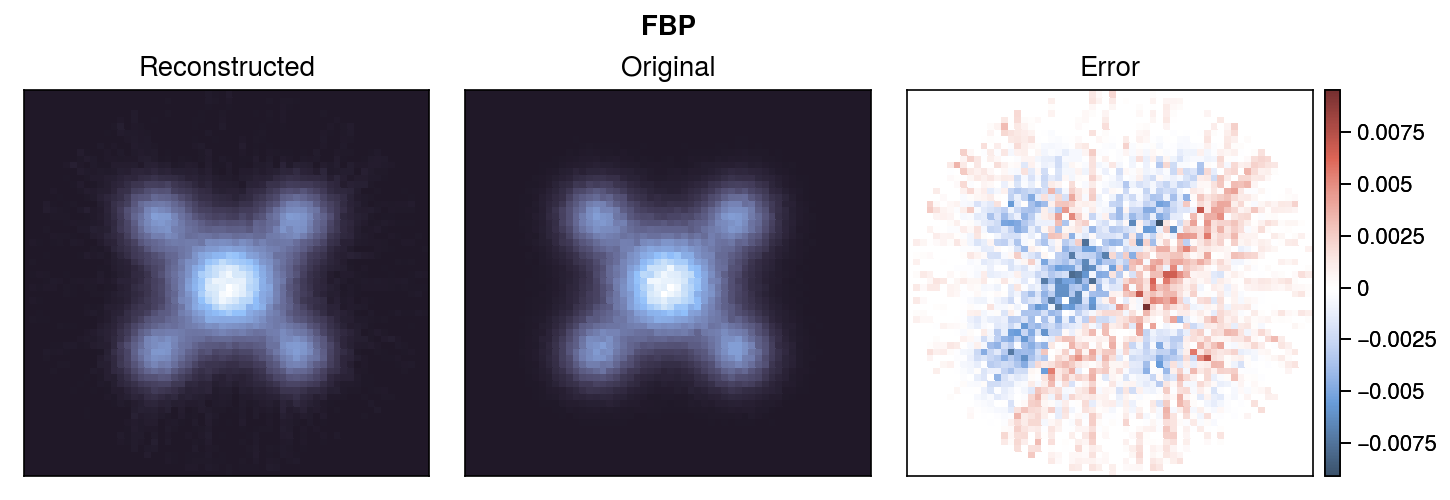

In [50]:
Z = transform.iradon(projections, theta=-angles).T
Z = process(Z, keep_positive=True, density=True, limits=limits)
plot_rec(Z, Z_true, 'FBP')

FBP generally requires a high number of projections to avoid these streaking artifacts. Let's see what happens when the number of projections is varied. In each case, we distribute the angles evenly over 180 degrees.

In [ ]:
# hide
# image = np.copy(Z_true.T)

# fig, ax = pplt.subplots(figsize=(3, 3))
# ax.axis('off')
# plt.close()

# def update(frame):
#     n = frame + 2
#     theta = np.linspace(0., 180., n, endpoint=False)
#     proj = transform.radon(image, theta, circle=False)
#     image_rec = transform.iradon(proj, theta, circle=False)
#     ax.imshow(image_rec, cmap='dusk_r')
#     ax.set_title('Number of angles = {}'.format(n))

# anim = animation.FuncAnimation(fig, update, frames=48, interval=(1000/5))
# anim.save('vary_n_angles.gif', dpi=300)

<img src=images_2021-10-16/vary_n_angles.gif width=300>

We were also careful to choose an angular range close to 180 degrees to maximize the information carried by the projections.

In [ ]:
# hide
# angular_range = np.linspace(10., 180., 50)
# n = 100

# fig, ax = pplt.subplots(figsize=(3, 3))
# ax.axis('off')
# plt.close()

# def update(i):
#     theta = np.linspace(0., angular_range[i], n)
#     proj = transform.radon(image, theta, circle=False)
#     image_rec = transform.iradon(proj, theta, circle=False)
#     ax.imshow(image_rec, cmap='dusk_r')
#     ax.set_title(r'{} angles;  {:.2f}$\degree$ range'.format(n, angular_range[i]))
    
# anim = animation.FuncAnimation(fig, update, frames=len(angular_range), interval=(1000/5))
# anim.save('figures/vary_angular_range.gif', dpi=300)

<img src=images_2021-10-16/vary_angular_range.gif width=300>

The angular range in an accelerator is determined by the amount of control we have over the optics between the reconstruction location and the measurement location. It's possible to run into problems here; for example, varying a magnet too far from its design value could make the beam unacceptably large at a downstream location. Magnets also have limited strengths, and sometimes they can't be controlled independently. Additionally, achieving a specific projection angle is not always straightforward; usually an optimizer is used to find the correct settings, and this takes time. I'll come back to these points later.

FBP can be generalized to 3D reconstruction from 2D projections, but it doesn't seem straightforward. I don't know if it could work for a 4D reconstruction from 2D projections. I'm just not sure what back-projection would mean in that case...

### Algebraic Reconstruction (ART) 

Algebraic reconstruction (ART) algorithms are simpler than FBP. The reconstructed $x$-$x'$ distribution will be defined on a grid. Let $\rho^{(k)}$ be a vector containing the $k$th projection, and let $\psi$ be a vector of the phase space density at the reconstruction location ($N^2$ elements for an $N \times N$ grid). Since we know the linear transformation connecting the two points, we can write the following matrix equation:

$$ \rho^{(k)} = P^{(k)}\psi, $$

Stack these equations for all the projections to get

$$ \rho = P \psi. $$

All we need to do is compute the pseudo-inverse of $P$. The problem is that $P$ could be huge. If there are $K$ projections, $P$ will be have $K N \times N^2$ elements. Inverting such a matrix could be a pain, so people have developed iterative methods to find the answer. Scikit-image has one ready to go called simultaneous algebraic reconstruction (SART).

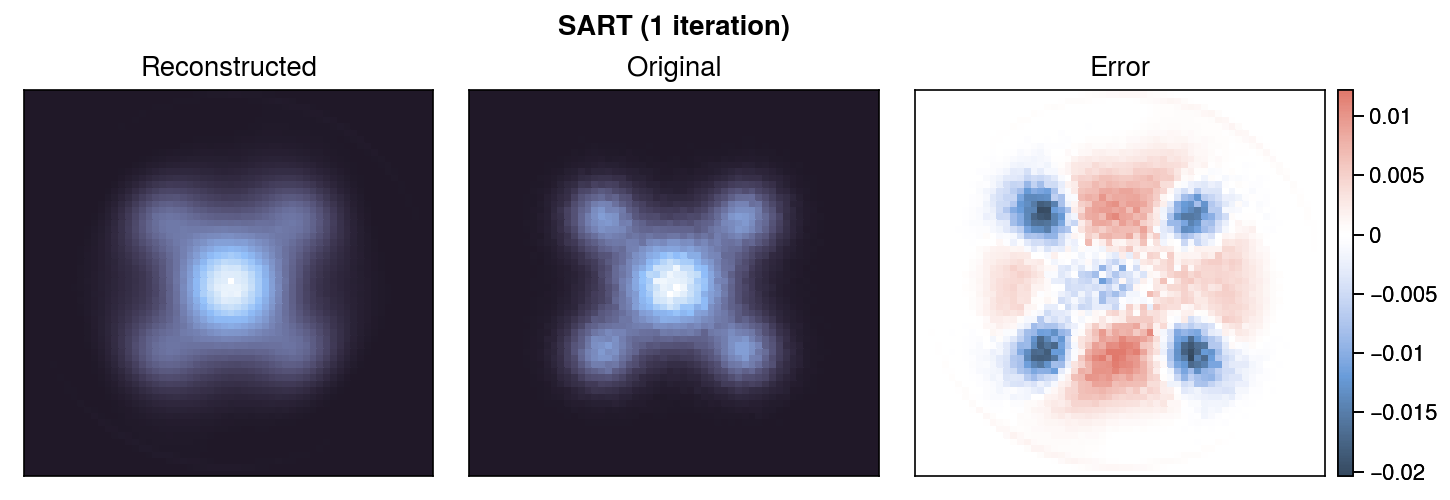

In [51]:
Z = transform.iradon_sart(projections, theta=-angles).T
Z = process(Z, keep_positive=True, density=True, limits=limits)
plot_rec(Z, Z_true, 'SART (1 iteration)')

The SART algorithm looks like it does better with fewer projections. SART is known to produce a good answer in only one iteration. Running it again with the original reconstruction as an initial estimate can sharpen image but may increase noise. In this case, it looks like running SART again leads to a better reconstruction without increasing noise.

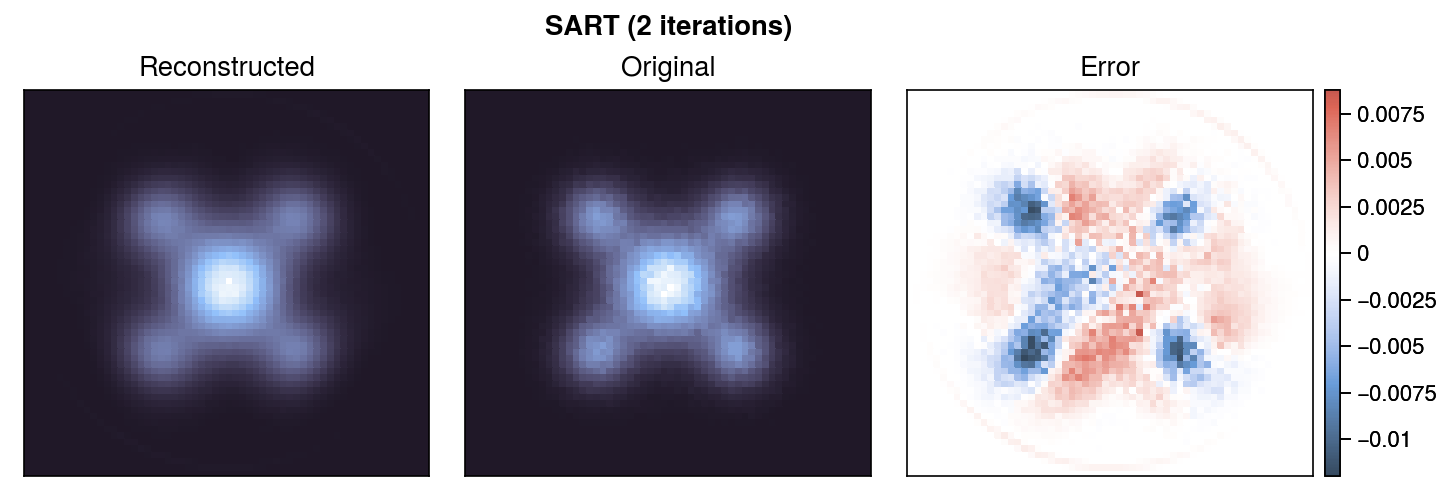

In [52]:
Z = transform.iradon_sart(projections, theta=-angles).T
Z = transform.iradon_sart(projections, theta=-angles, image=Z.T).T
Z = process(Z, keep_positive=True, density=True, limits=limits)
plot_rec(Z, Z_true, 'SART (2 iterations)')

ART easily generalizes to 4D, but it could become expensive since $P$ would have $K N^2 \times N^4$ elements. This has been carried out by Wolski (2021) with $N = 69$. I'll leave investigation of 4D ART for a future post.

### MENT

There is another approach to the problem based on information theory. The idea is that the most probable distribution should be chosen, i.e., find the $f(\mathbf{x})$ that maximizes the entropy

$$ S = -\int f(\mathbf{x}) \log{f(\mathbf{x})} d\mathbf{x}$$

with the constraint that the projections of $f(\mathbf{x}$ are consistent with measurements. The theory behind this algorithm is layed out in Minerbo (1972). The benefit to MENT is that it has a goal in mind and can do very well with only a few projections where ART might introduce significant streaking artifacts. The downside of MENT is that although it *can* work well with few projections, there is no guarantee, and it may struggle to converge when many projections are used. Unfortunately, this algorithm is a bit tricky to implement; I'm working on it.  

MENT can also work in 4D with 2D projections *or 1D projections*; the math is pretty much the same.

### Grid-based methods

There is a final method that I should mention: using multi-particle simulation to find the answer. Start with a bunch of particles and transport them to the measurement location. Throw away particles that landed in bins in which the measured projection is zero. Now, generate new particles in the viscinity of the old ones with the number of new particles proportional to the measured distribution in that bin. Repeat until convergence.

The advantage of this approach is that it works for any number of dimesions and can also include nonlinear effects in the simulation such as space charge. I'm wondering, though, if this just reduces to a version of ART if the transport is linear; our beam is high energy, which means that space charge can mostly be ignored over short distances. Again, I'll leave this method for a future post.

## 4D reconstruction 

I've mentioned that at least three methods (ART, MENT, grid-based) will generalize to 4D reconstruction from 2D projections. But what I'd like to look at now is a different, hopefully easier method described in Hock (2013). The method uses 2D projections but only uses 2D reconstruction methods like those described in this post. It's sort of like a CT scan: 1D projections are used to reconstruct a 2D slice of a human body, and then the slice is moved along the body to reconstruct the 3D image. This would be nice because the conditions for a good 2D reconstruction are well-understood, but might not be clear for higher-dimensional versions of the algorithms.

First, we need a 4D distribution.

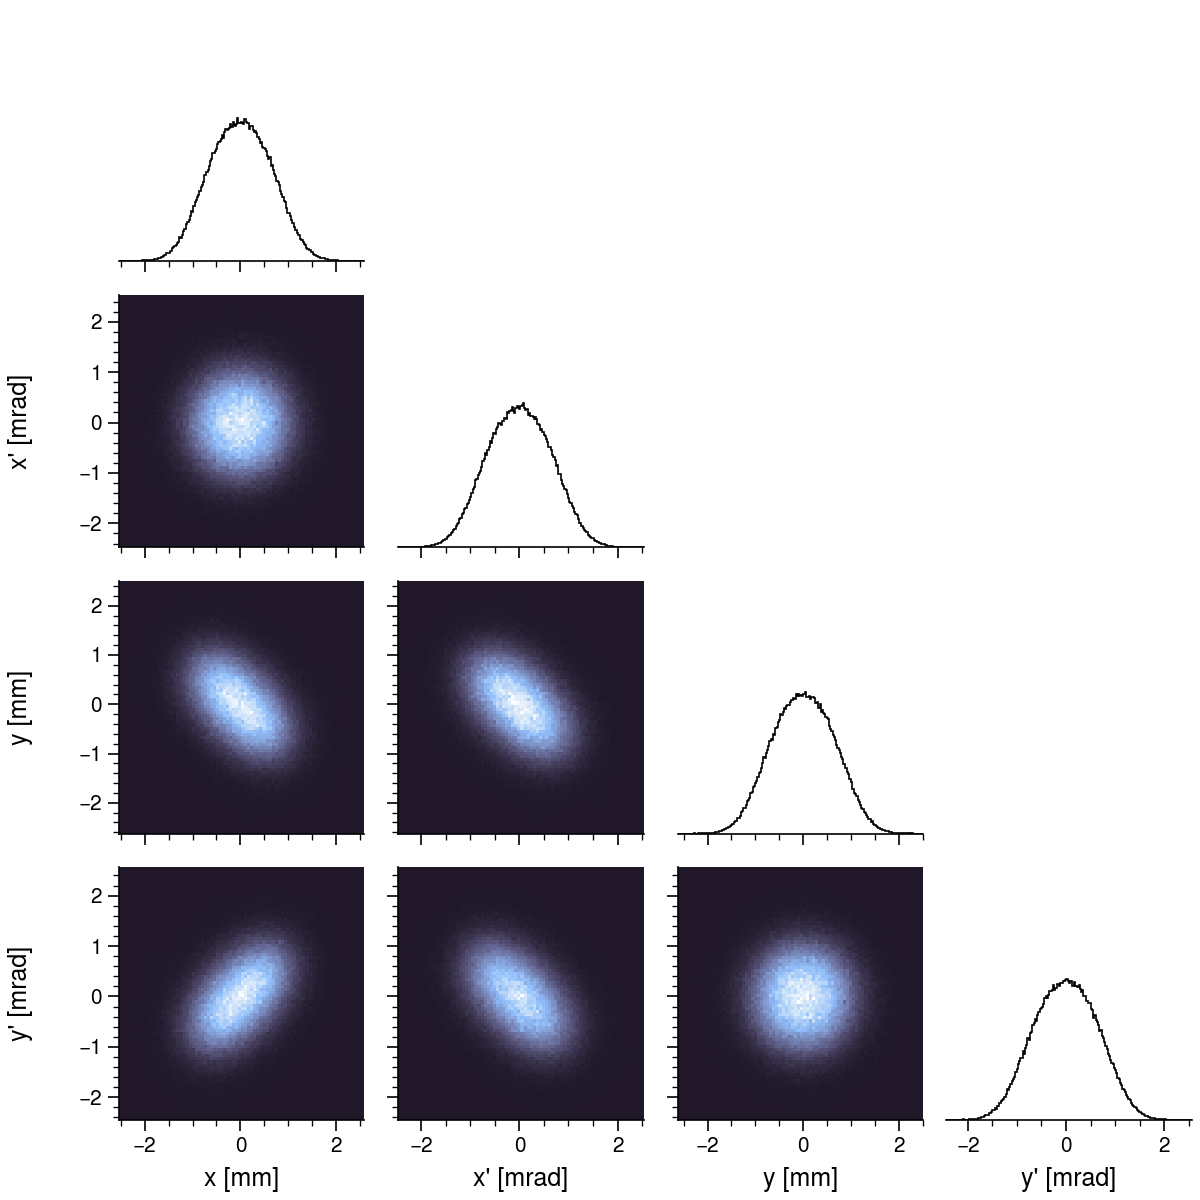

In [54]:
# Create a rigid rotating distribution.
X = np.random.normal(size=(400000, 4))
X = np.apply_along_axis(lambda row: row / np.linalg.norm(row), 1, X)
X[:, 3] = +X[:, 0]
X[:, 1] = -X[:, 2]

# Change the x-y phase difference.
R = np.zeros((4, 4))
R[:2, :2] = rotation_matrix(np.pi / 4)
R[2:, 2:] = rotation_matrix(0.0)
X = np.apply_along_axis(lambda row: np.matmul(R, row), 1, X)

# Add some noise.
X += np.random.normal(scale=0.4, size=X.shape)

# Plot the 2D projections.
n_bins = 80
axes = myplt.corner(X, figsize=(6, 6), bins=n_bins)
plt.show()

# Store the limits for each dimension.
limits = [ax.get_xlim() for ax in axes[-1, :]]
labels = ["x", "x'", "y", "y'"]

We can get the "true" distribution by binning the particles on a 4D grid.

In [55]:
Z_true, edges = np.histogramdd(X, n_bins, limits, density=True)
centers = []
for _edges in edges:
    centers.append(0.5 * (_edges[:-1] + _edges[1:]))
    
bin_volume = get_bin_volume(limits, n_bins)

### Description of Hock's method 

Now for the method. Suppose we can independently rotate the $x$-$x'$ and $y$-$y'$ projections of the phase space distribution. Let the angles in $x$-$x'$ be $\left\{\mu_{x_1}, \dots, \mu_{x_k}, \dots, \mu_{x_K}\right\}$ and the angles in $y$-$y'$ be $\left\{\mu_{y_1}, \dots, \mu_{y_l}, \dots, \mu_{y_L}\right\}$. For each combination of $\mu_x$ and $\mu_y$, we measure the beam intensity on a screen. In other words, we create a matrix $S$ such that $S_{ijkl}$ gives the intensity at point $(x_i, y_j)$ on the screen for phase advances (angles) $\mu_{x_k}$ and $\mu_{y_l}$.

In [56]:
K = 15 # number of angles in x dimension
L = 15 # number of angles in y dimension
muxx = muyy = np.linspace(0., 180., K, endpoint=False)

xx_list = []
for mux in muxx:
    Mx = rotation_matrix(np.radians(mux))
    xx_list.append(apply(Mx, X[:, :2])[:, 0])
    
yy_list = []
for muy in muyy:
    My = rotation_matrix(np.radians(muy))
    yy_list.append(apply(My, X[:, 2:])[:, 0])
    
S = np.zeros((n_bins, n_bins, K, L))
for k, xx in enumerate(xx_list):
    for l, yy in enumerate(yy_list):
        S[:, :, k, l], _, _ = np.histogram2d(xx, yy, n_bins, (limits[0], limits[2]))

In [57]:
#hide
# fig, ax = pplt.subplots(figsize=(3, 3))
# ax.format(xlabel="x", ylabel="y", xticks=[], yticks=[])
# plt.close()

# def update(frame):
#     k = frame // 15
#     l = frame % 15
#     mux = np.degrees(muxx[k])
#     muy = np.degrees(muyy[l])
#     dist = S[:, :, k, l]
#     ax.pcolormesh(centers[0], centers[2], dist)
#     ax.set_title(r'$\mu_x = {:.2f}\degree$   $\mu_y = {:.2f} \degree$'.format(mux, muy))
    
# frames = 3 * L - 1
# fps = 7.5
# anim = animation.FuncAnimation(fig, update, frames=frames, interval=(1000.0/fps))
# anim.save('figures/target_phase_scan.gif', dpi=300)

<img src=images_2021-10-16/target_phase_scan.gif width=300>

The above animation shows a few steps in the scan; since the transfer matrices are rotation matrices, only the cross-plane correlation changes.

We can immediately reconstruct the 3D projection the 4D phase space distribution using this data. Consider one row of the beam image — the intensity along the row gives a 1D projection onto the $x$ axis for a vertical slice of the beam. We have a set of these 1D projections at different $\mu_k$ which we can use to reconstruct the $x$-$x'$ distribution at this vertical slice using any 1D $\rightarrow$ 2D reconstruction method. I'll use SART since this seemed to work well with 15 projections. We repeat this at each slice. We thus have an array $D$ such that $D_{j,l,r,s}$ gives the density at $x = x_r$, $x' = x'_s$ for $y = y_j$ and $\mu_y = \mu_{y_l}$.    

In [58]:
D = np.zeros((n_bins, L, n_bins, n_bins))
for j in range(n_bins):
    for l in range(L):
        _Z = transform.iradon_sart(S[:, j, :, l], theta=-muxx).T
        _Z = transform.iradon_sart(S[:, j, :, l], theta=-muxx, image=_Z.T).T
        D[j, l, :, :] =_Z

I should also mention that the reconstruction grid doesn't need to be the same size as the measurement grid. We can now do a similar thing in the vertical plane. For each bin in the reconstructed x-x' grid, `D[:, :, r, s]` gives the projections of $y$-$y'$ at each $\mu_{y_l}$; thus, $y$-$y'$ can be reconstructed at each $x_r$ and $x'_s$, and we have an array $Z$ such that $Z_{r,s,t,u}$ gives the density at $x = x_r$, $x' = x'_s$, $y = y_t$, $y' = y'_u$.

In [59]:
Z = np.zeros((n_bins, n_bins, n_bins, n_bins))
for r in range(n_bins):
    for s in range(n_bins):
        _Z = transform.iradon_sart(D[:, :, r, s], theta=-muyy).T
        _Z = transform.iradon_sart(D[:, :, r, s], theta=-muyy, image=_Z.T).T
        Z[r, s, :, :] = _Z

### Accuracy

ART could make some bins negative, so set those to zero. We then need to normalize `Z` for comparison with `Z_true`.

In [60]:
Z = process(Z, keep_positive=True, density=True, limits=limits)
print('min(Z) = {}'.format(np.min(Z)))
print('max(Z) = {}'.format(np.max(Z)))
print('sum(Z) * bin_volume = {}'.format(np.sum(Z) * bin_volume))
print()
print('min(Z_true) = {}'.format(np.min(Z_true)))
print('max(Z_true) = {}'.format(np.max(Z_true)))
print('sum(Z_true) * bin_volume = {}'.format(np.sum(Z_true) * bin_volume))

min(Z) = 0.0
max(Z) = 0.1857948534308458
sum(Z) * bin_volume = 1.0000000000000009

min(Z_true) = 0.0
max(Z_true) = 1.0871141217231883
sum(Z_true) * bin_volume = 0.9999999999999928


I'm not sure the best way to quantify the difference between the distributions. My initial thought is to subtract `Z_true` from `Z`, take the absolute value, and divide by the number of bins; this would give the average absolute error over the bins.

In [61]:
avg_abs_err_per_bin = np.sum(np.abs(Z - Z_true)) / Z.size
print('Average absolute error per bin = {}'.format(avg_abs_err_per_bin))

Average absolute error per bin = 0.0022348305273901144


Lots of bins are empty so this might not be the most meaningful number. For now, it's probably more helpful to view the differences between the projections.

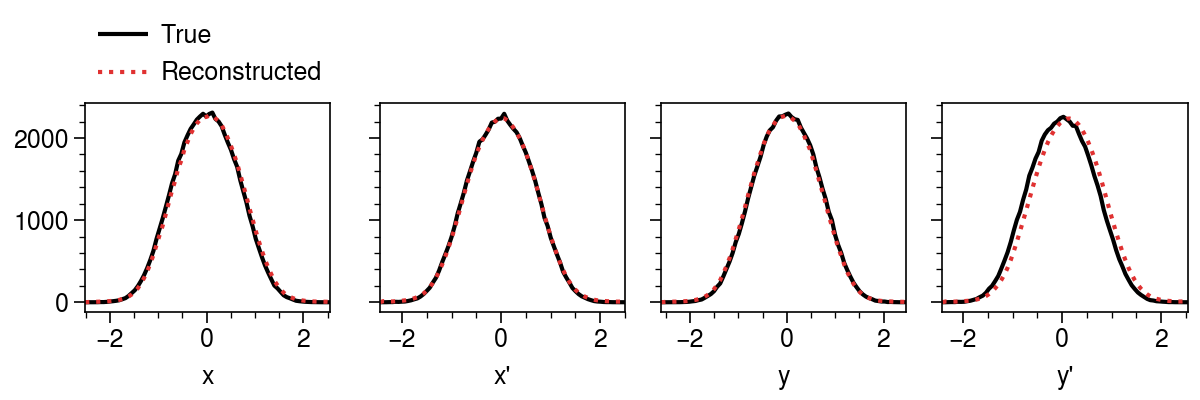

In [62]:
#collapse
fig, axes = pplt.subplots(ncols=4, figsize=(6, 2), spanx=False)
for i in range(4):
    axes[i].plot(centers[i], project(Z_true, i), color='black', label='True')
    axes[i].plot(centers[i], project(Z, i), color='red8', 
                 ls='dotted', label='Reconstructed')
    axes[i].set_xlabel(labels[i])
axes[0].legend(loc=(0.0, 1.02), framealpha=0.0, ncol=1);

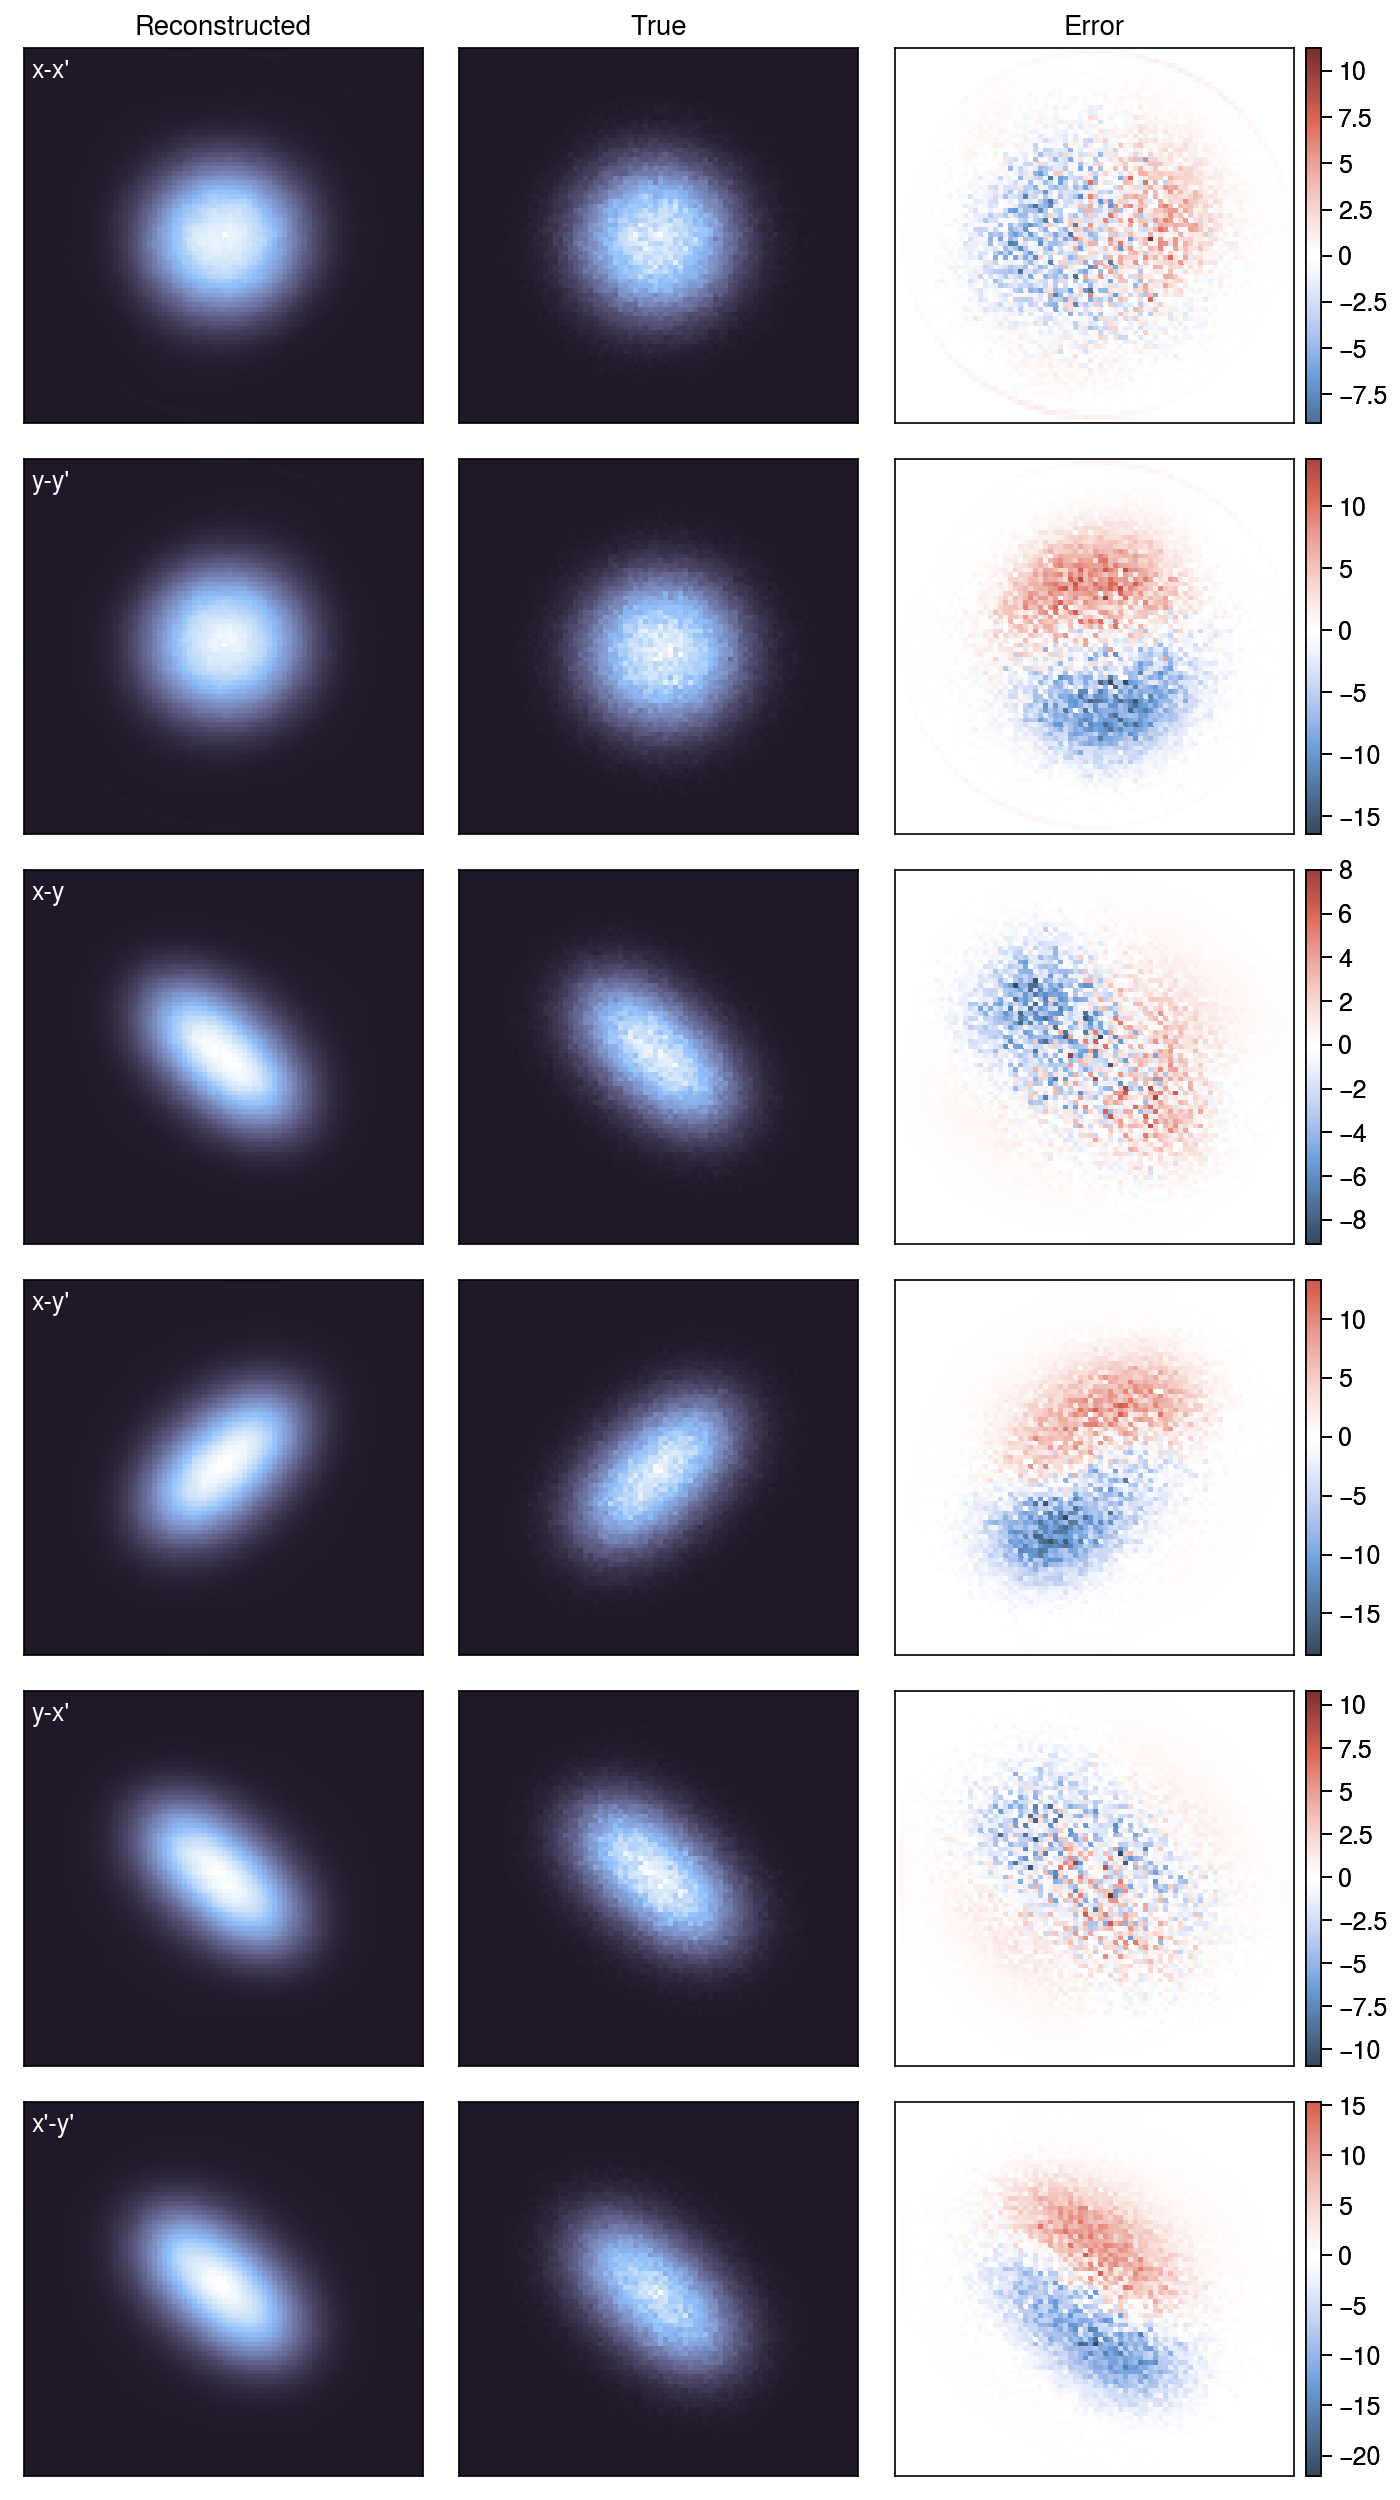

In [67]:
#collapse
indices = [(0, 1), (2, 3), (0, 2), (0, 3), (2, 1), (1, 3)]
fig, axes = pplt.subplots(nrows=6, ncols=3, figsize=(7.0, 12.5), 
                          sharex=False, sharey=False)
for row, (i, j) in enumerate(indices):
    _Z_true = project(Z_true, [i, j])
    _Z = project(Z, [i, j])
    axes[row, 0].pcolormesh(centers[i], centers[j], _Z.T, cmap='dusk_r')
    axes[row, 1].pcolormesh(centers[i], centers[j], _Z_true.T, cmap='dusk_r')
    axes[row, 2].pcolormesh(centers[i], centers[j], (_Z - _Z_true).T, 
                            colorbar=True, colorbar_kw=dict(width=0.075))
    axes[row, 0].annotate('{}-{}'.format(labels[i], labels[j]),
                          xy=(0.02, 0.92), xycoords='axes fraction', color='white')
for ax, title in zip(axes[0, :], ['Reconstructed', 'True', 'Error']):
    ax.set_title(title)
axes.format(xticks=[], yticks=[]);

In the second plot, the error is given in number of particles. It looks like the method worked well to reconstruct this distribution. 

### Feasibility 

#### Target imaging system 

The SNS target is a steel vessel containing liquid mercury. At the beginning of this post, I mentioned that the SNS has a target imaging system. Here is a diagram showing how the target imaging system works...

<img src=images_2021-10-16/target_image_system.png>

... and an example of an image.

<img src=images_2021-10-16/target_image.png >

To reduce noise, the image was averaged over five beam pulses and a Gaussian blur was applied with $\sigma = 3$. There are four fiducial markers that are visible as dark spots on the corner of the beam. The black ellipse represents a measurement from wire-scanners upstream of the target. Collecting this image is easy.

#### Optics control

I've assumed that the transfer matrices connecting the coordinates are simple rotation matrices. Although that isn't true in reality, there is a trick we can play. Any transfer matrix $M$ can be writen as the product $M = V R V^{-1}$, where $V$ provides shearing + scaling and $R$ is a rotation by the phase advances $\mu_x$ and $\mu_y$. Applying $V^{-1}$ to the coordinates is called *normalizing* the coordinates. What we can do is normalize (scale) the measured profiles, perform the reconstruction in normalized phase space, then unnormalize the reconstructed distribution. 

In normalized phase space, the transfer matrices are just rotation matrices ($R$) and the projection angles are the phase advances. This is an advantage because the phase advances are easier to control than the true projection angles. Also, the reconstructed $x$-$x'$ and $y$-$y'$ projections will be somewhat circular in this space, which should reduce errors.

The (un)normalization steps will involve interpolation since we're performing a transformation on an image, and I'm not yet sure how this will affect the reconstruction error. Anyhow, we don't *have* to reconstruct in normalized phase space if this turns out to be an issue.

So, the question is whether we can independently vary the $x$ and $y$ phase advances at the target, and if so, by how much. There are five independent quadrupoles before the target — three focusing and two defocusing — QH26, QV27, QH28, QV29 and QH30. Before that, there are eight quadrupoles — four focusing and four defocusing — that share two powers supplies. One power supply controls QH18, QH20, QH22, and QH24, and another controls QV19, QV21, QV23, and QV25. 

There are also a constraints. First, the beam size far away from the target should remain small. We measure the beam size using the $\beta$ function, which should remain below 35 [m/rad]. The beam becomes much larger close to the target; there, the $\beta$ function should remain below 100 [m/rad]. Finally, the SNS target has tight constraints on the beam size and the beam density. It's safest to keep the $\beta$ functions within 10 or 20 percent of the design value.  

I plugged all this into an optimizer and asked to vary the phase advances in a 180 degree range. After fideling with the starting and ending phases, I was able to more-or-less do this. I used 15 phase advances in $x$ and 15 phase advances in $y$, just like in this post. Each optimization took around 16 seconds, so the script took around an hour to run. Below are the computed phase advances at each step as well as the strengths of the seven magnet power supplies.

<img src=images_2021-10-16/target_phase_scan1.png>

There are a few steps near the end of the scan in which the phase advances aren't exactly correct, but they are close. I can always decrease the phase coverage slighly, or maybe these steps just need a slightly different initial guess. Here are the beta functions for all steps in one plot. The plot ends at the target.

<img src=images_2021-10-16/target_phase_scan2.png >

The bottom plot is just the integral of the inverse of the top plot. The beta functions remain within their limits.

### Outlook 

Initial tests of Hock's 4D reconstruction method are promising. There are a number of things to investigate. Ideally, the minimum number of projections is used. First, I should play with the number of projections using ART to see how the reconstruction error scales. I would also like to implement MENT, which should do better with fewer projections. I should then test the "direct" 4D reconstruction methods such as ART, MENT, or grid-based and compare them to Hock's method. I should also investigate how the methods respond to noise, changes in the grid size, and more complex distributions.

The script to perform the data collection for this method is pretty simple: compute the correct optics, update the live magnet strengths accordingly, send a beam to the target, and save the target image. The biggest issue is execution time. In our next study at the SNS, we'll have plenty of time to run the script in addition to our other tasks. Hopefully this will be a helpful diagnostic.